In [403]:
import warnings
warnings.filterwarnings("ignore")
from utils import *  # вспомогательные функции, вынесены в отдельный модуль

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier, Pool
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from borutashap import BorutaShap

import optuna
from optuna.samplers import TPESampler
from pprint import pprint

seed = 123
np.set_printoptions(4)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

1. выполнить анализ и охарактеризовать клиентский портфель организации
2. построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.
3. подготовить рекомендации и предложения по изменению признакового пространства, использованию внешних данных и иному развитию базовой модели.

In [22]:
data = pd.read_csv("credit_train.csv", index_col="Unnamed: 0")  # "Unnamed: 0" - не похоже на id-клиента
data.sample(5)

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
26734,45.0000,7.0000,0.0000,0.0000,14.0000,8.0000,10.0000,1.0000,62650.0000,5.0000,89519.0000,6.0000,0.0000,0.0000,62650.0000,3.0000,62650.0000,4.0000,0.0000,0.0000,62650.0000,3.0000,62650.0000,0.0000,0.0000,62650.0000,0.5714,0.0000,0.0556,0.0000,0.6111,0.0000,0.3889,0.0000,0.1667,13.2500,4.5938,0.0000,0.0000,0.0000,32.0000,1.0000,0.0000,0.0000,0.0000,0.0000,7.0000,10.0000,6.0000,14.0000,4.0000,1.0000,3.0000,1.0000,1.0000,14.0000,1.0000,1.0000,3.0000,0.0000,0.0000,8.0000,0.0000,0.0000,3.0000,0.0000,0.0000,3.0000,0.0000,0.0000,3.0000,120.0000,-0.0535,0.0000
11960,53.0000,2.0000,0.0000,0.0000,118.5000,6.0000,6.0000,0.0000,44000.0000,4.0000,144000.0000,1.0000,0.0000,0.0000,44000.0000,3.0000,119000.0000,1.0000,0.0000,0.0000,19000.0000,2.0000,19000.0000,1.0000,0.0000,19000.0000,0.7500,0.0000,0.0000,0.0000,0.4167,0.0000,0.3333,0.0000,0.2500,2.7692,0.0000,0.0000,0.0000,0.0000,13.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,4.0000,4.0000,4.0000,2.0000,1.0000,3.0000,1.0000,0.0000,4.0000,1.0000,0.0000,3.0000,1.0000,0.0000,3.0000,1.0000,0.0000,2.0000,0.0000,0.0000,3.0000,0.0000,0.0000,2.0000,120.0000,0.0000,0.0000
16964,49.0000,2.0000,0.0000,0.0000,11.0000,24.0000,60.0000,0.0000,504327.0000,21.0000,798770.0000,14.0000,0.0000,0.0000,504327.0000,15.0000,320838.0000,3.0000,0.0000,0.0000,320838.0000,10.0000,196216.0000,1.0000,0.0000,196216.0000,0.5806,0.0000,0.0000,0.0000,0.4167,0.0000,0.2143,0.0000,0.1310,3.2551,0.2959,0.0000,0.0000,0.0000,98.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,9.0000,11.0000,73.0000,4.0000,3.0000,17.0000,2.0000,2.0000,31.0000,2.0000,2.0000,17.0000,0.0000,0.0000,18.0000,0.0000,0.0000,15.0000,0.0000,0.0000,10.0000,0.0000,0.0000,10.0000,120.0000,0.0000,1.0000
14302,29.0000,10.0000,0.0000,0.0000,1.0000,4.0000,18.0000,1.0000,24120.0000,4.0000,24120.0000,15.0000,0.0000,0.0000,24120.0000,4.0000,24120.0000,15.0000,0.0000,0.0000,24120.0000,4.0000,24120.0000,4.0000,0.0000,24120.0000,1.0000,0.0000,0.0455,0.0000,0.8636,0.0000,0.8636,0.0000,0.3636,13.8462,0.0000,0.0000,0.0000,0.0000,26.0000,1.0000,0.0000,0.0000,0.0000,0.0000,10.0000,0.0000,2.0000,24.0000,0.0000,0.0000,4.0000,0.0000,0.0000,23.0000,0.0000,0.0000,4.0000,0.0000,0.0000,23.0000,0.0000,0.0000,4.0000,0.0000,0.0000,10.0000,0.0000,0.0000,4.0000,120.0000,0.4146,1.0000
1596,27.0000,2.0000,1.0000,0.0000,1.0000,24.0000,14.0000,0.0000,238829.0000,23.0000,804502.0000,13.0000,0.0000,0.0000,238829.0000,20.0000,238829.0000,13.0000,0.0000,0.0000,238829.0000,11.0000,107271.0000,2.0000,0.0000,

In [239]:
features = data.columns.tolist()[:-1]

In [23]:
data.describe()

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,42529.0000,42529.0000,42529.0000,42520.0000,42520.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42497.0000,35685.0000,42529.0000,42506.0000,42529.0000,42311.0000,42529.0000,42136.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,39968.0000,42529.0000,42520.0000,42520.0000,42520.0000,42520.0000,42520.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,42529.0000,39729.0000,42529.0000
mean,34.8101,10.6357,127.2191,0.3418,208.4101,20.5140,59.1264,0.6011,273248.6420,17.9787,434158.2253,41.2514,0.3338,0.0000,263018.5553,15.3950,251713.5213,17.8082,0.1966,0.0000,224423.3871,10.9077,152407.5220,3.6561,0.0501,144473.9193,0.6645,0.0000,0.0101,0.0060,0.7652,0.0055,0.5022,0.0032,0.2513,6.1314,1.2596,0.3601,0.1211,0.2353,96.0749,0.2616,0.0008,0.0006,0.0004,0.0205,80.7279,3.1262,5.4356,85.0833,2.0485,1.1926,17.2274,0.7929,1.1686,66.4543,0.7176,0.5577,16.6902,0.1386,0.4124,38.0212,0.1328,0.1867,15.0728,0.0323,0.1703,16.7447,0.0314,0.0995,10.7758,105.6475,NaN,0.2775
std,8.8242,75.4806,2343.8240,13.0845,2694.4633,14.0961,93.7705,1.6778,257212.9577,12.9629,754649.7459,53.4510,1.1267,0.0000,250250.6209,11.3710,341810.3005,21.2406,0.7335,0.0000,204276.1173,8.5902,215238.4879,5.6946,0.3363,137133.1496,0.2705,0.0000,0.0304,0.0266,0.2371,0.0227,0.2573,0.0227,0.1835,10.1002,3.3764,1.2402,0.4643,0.3715,120.4022,0.4340,0.0143,0.0108,0.0095,0.1089,1762.0856,3.3599,7.6697,116.7210,2.2119,1.7035,12.2685,1.3270,2.4593,70.2798,1.1999,1.0745,12.3036,0.5230,1.1812,35.3701,0.5011,0.5441,11.2056,0.2599,0.6008,15.9451,0.2482,0.3807,8.5097,36.6311,NaN,0.4477
min,18.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0

много признаков имеют скошенное вправо распределение, необходимо разобраться выбросы это или нет
(вернее, имеют ли данные выбросы естественную природу или нет, например, last_microloan_openeddt = 44778 дней = 122 года
- сомнительно)

В данных признаках есть очень высокие или экстремальные значения

что можно сделать: 
* если выборосы случайны: 
 1) удалить
 2) заменить статистикой, вычисленной на обучающем наборе
 3) провести виндзоризацию (по IQR, 5-95 или 0-99 перцентилям)

* Если не случайны и это особенность распределения данных, то преобразовать  (если это требует алгоритм обучения, например, LogisticRegression, метрические алгоритмы типо KNN и т.п.):
 1) правый скос: np.reciprocal, log (ln, log2, log10), sqrt (2, 4), etc  
 2) левый скос: exp, sqrt(3) etc
 3) box-cox (x > 0), yeo-johnson (Любой x)
* в "деревянных" алгоритмах не важно, если это не целевая переменная или, например, бустинг не использует квантизация по min-max

* есть сомнения: можно добавить переменную индикатор

**Претенденты на выбросы**
- last_microloan_openeddt
- count_all_credits 
- is_type_micro_1 
- is_active_type_micro_3
- is_type_micro_3 
- is_active_type_micro_12
- is_type_micro_12
- is_type_micro_100
- is_type_consumer_100
- count_all_credits
- isnt_active_12
- is_lost_100
- isnt_active_100 - странная доля
- open_loan_median
- time_to_lastcredit_closeddt 

* скорее всего есть особенность заполнения данных в БД, так как очень большие похожие значения встречаются в обоих наборах предоставленных данных (как видно далее) - клиенты, не бравшие кредит или информация по которым отсутствует.

In [24]:
# проверим наличие повторяющихся образцов, константных признаков
data = check_duplicates_and_constants(data)

Initial train shape: (42529, 74)
Duplicates in train: 197
overdue_loans_12 in train set is constant, removed from train set.
overdue_loans_3 in train set is constant, removed from train set.
ratio_overdue_loans_3_to_12 in train set is constant, removed from train set.
Final train shape: (42332, 71) 

In [25]:
# есть дисбаланс в распределении классов, но не критичный
# пути решения: ресэмплинг (over-, under-, генерация - smote), усиленный штраф модели через веса классов
# задание весов классов лучше делать на финальных этапах для небольшого буста (возможного), 
# модель должна уже хорошо разделять классы к этому моменту. При таком дисбалансе высоких весов или ресэмлинга можно избежать

data["target"].value_counts(normalize=True)

target
0.0000   0.7230
1.0000   0.2770
Name: proportion, dtype: float64

<Axes: >

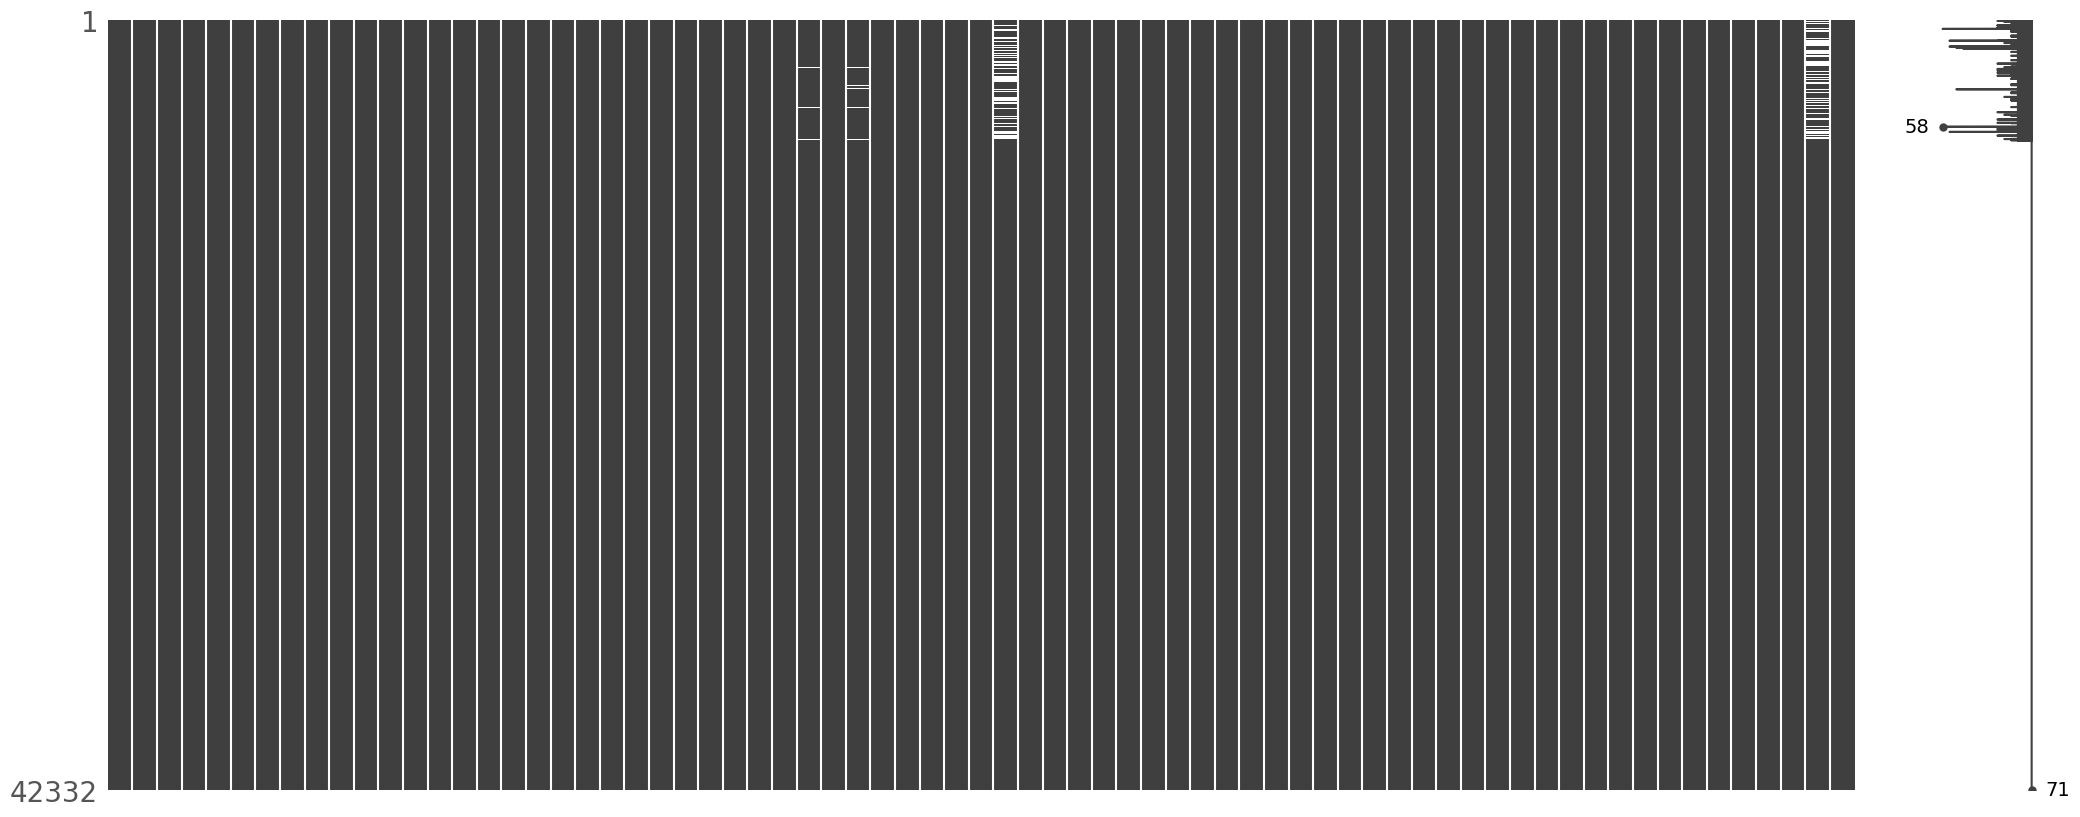

In [33]:
msno.matrix(data)  # пропусков немного

<Axes: >

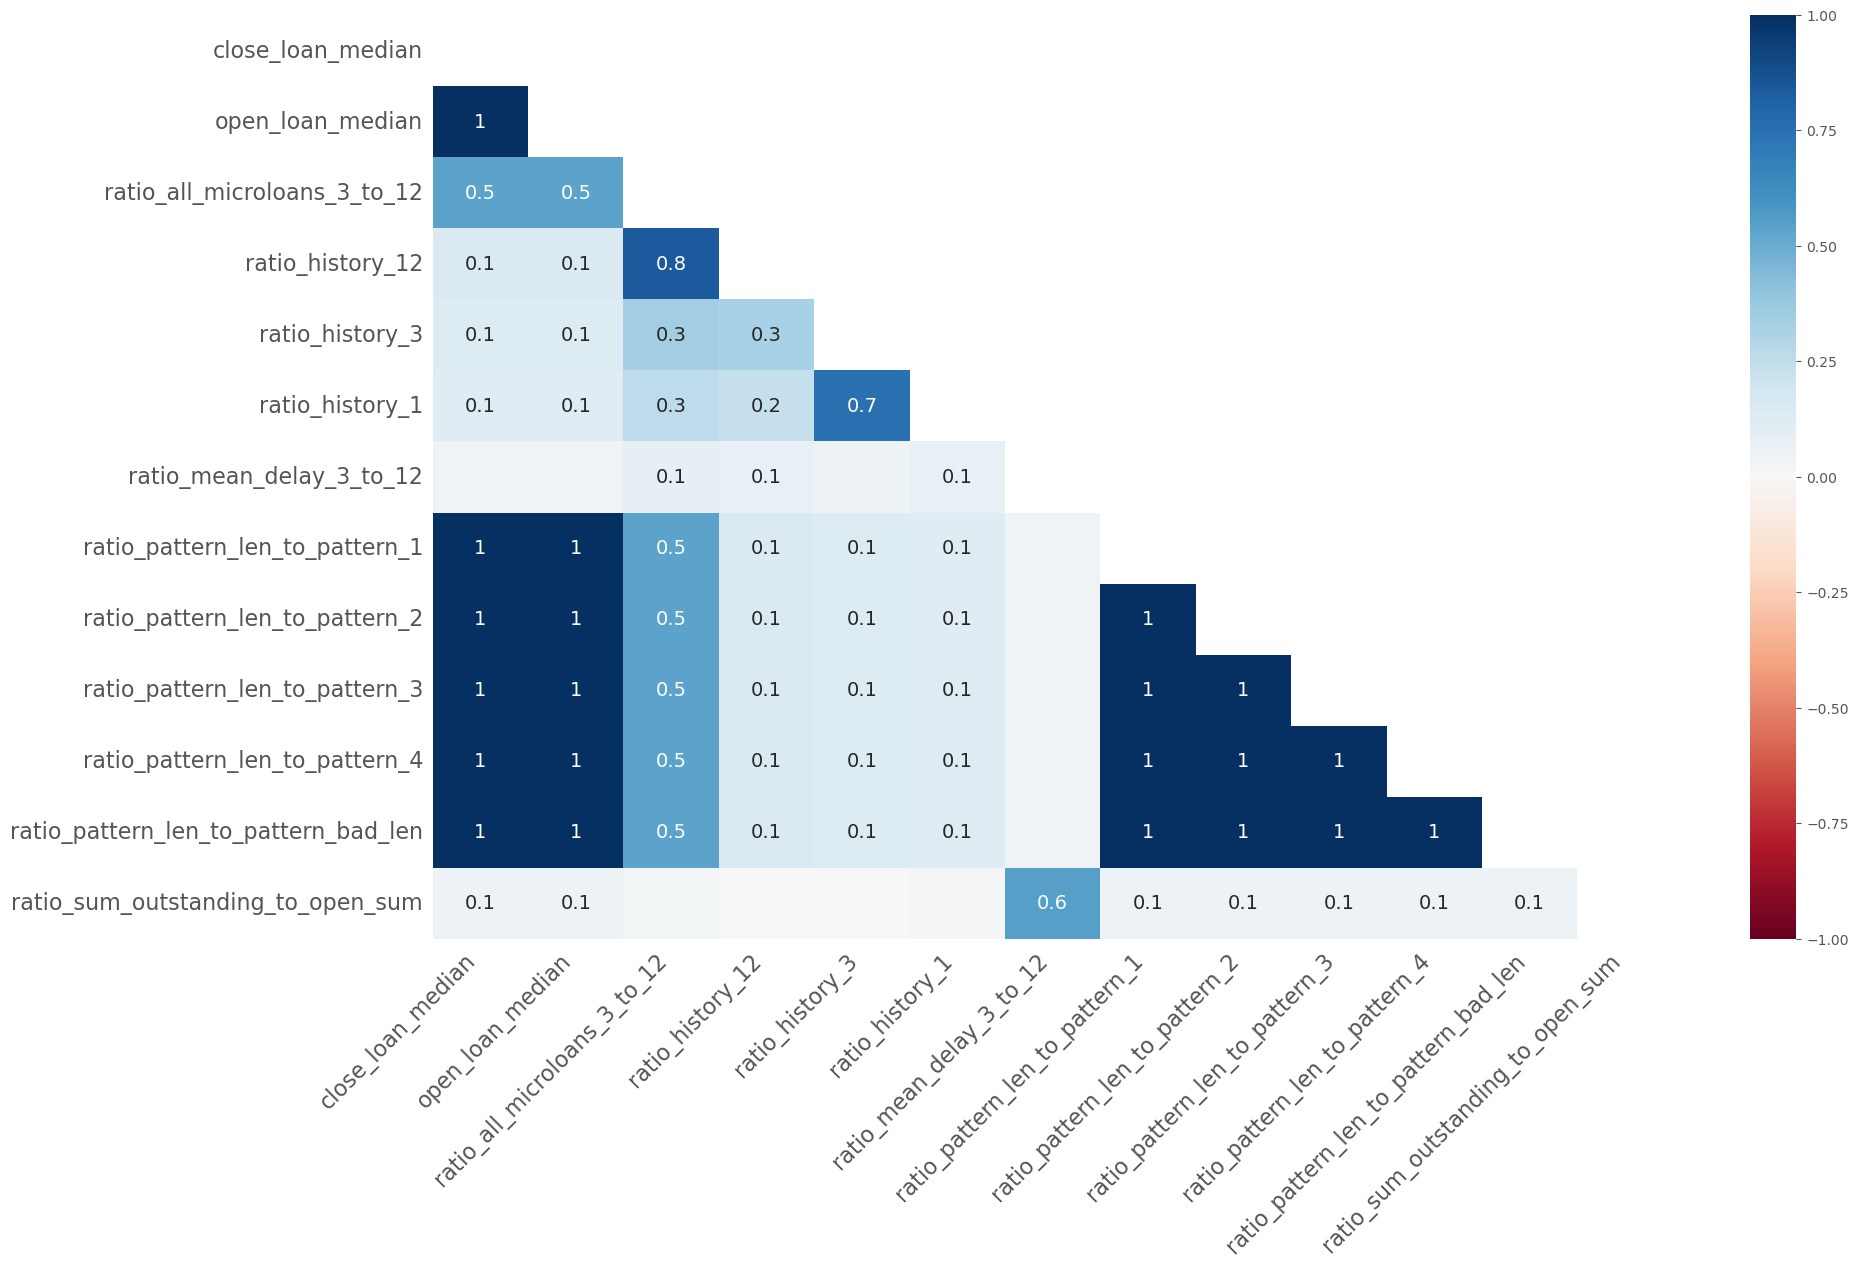

In [34]:
msno.heatmap(data)  # при этом многие значения в признаках закономерно пропущены не случайно
# в причинах пропусков можно также разбираться, чтобы понять чем их заменить
# в бейзлайне можно использовать возможности алгоритма обучения (если он есть)

In [224]:
# фактическая доля пропусков
check_missings(data)

Total NA-values = 5928


,close_loan_median,open_loan_median,ratio_all_microloans_3_to_12,ratio_history_12,ratio_history_3,ratio_history_1,ratio_mean_delay_3_to_12,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,ratio_sum_outstanding_to_open_sum
Total,9,9,31,22,212,383,2497,9,9,9,9,9,2720
Percent,0.0213,0.0213,0.0732,0.0520,0.5008,0.9048,5.8986,0.0213,0.0213,0.0213,0.0213,0.0213,6.4254
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [273]:
data[data["close_loan_median"].isna()]  # не открывали микрокредитов (остальные с пропусками види)

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target,nan_ind
1397,30.0000,875.0000,44690.0000,NaN,NaN,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,NaN,0.0000,NaN,0.0000,NaN,0.0000,7.2500,0.0000,0.0000,0.0000,NaN,4.0000,NaN,NaN,NaN,NaN,NaN,44690.0000,3.0000,1.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,1.0000,1
3274,60.0000,8.0000,44706.0000,NaN,NaN,5.0000,0.0000,0.0000,0.0000,5.0000,811001.0000,0.0000,0.0000,0.0000,1.0000,20000.0000,0.0000,0.0000,0.0000,1.0000,20000.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,1.0000,0.0000,0.2000,0.0000,0.2000,4.8333,4.8333,0.0000,0.0000,0.0000,6.0000,NaN,NaN,NaN,NaN,NaN,44706.0000,4.0000,1.0000,0.0000,4.0000,1.0000,0.0000,4.0000,1.0000,0.0000,4.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,NaN,0.0000,1
3282,31.0000,103.0000,44706.0000,NaN,NaN,4.0000,7.0000,0.0000,0.0000,4.0000,676326.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.7273,NaN,0.0000,NaN,0.0000,4.1429,0.0000,0.0000,0.0000,NaN,14.0000,NaN,NaN,NaN,NaN,NaN,44706.0000,3.0000,11.0000,0.0000,1.0000,3.0000,0.0000,3.0000,6.0000,0.0000,1.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,1
4426,31.0000,107.0000,44710.0000,NaN,NaN,4.0000,7.0000,0.0000,0.0000,4.0000,676326.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.7273,NaN,0.0000,NaN,0.0000,4.1429,0.0000,0.0000,0.0000,NaN,14.0000,NaN,NaN,NaN,NaN,NaN,44710.0000,3.0000,11.0000,0.0000,1.0000,3.0000,0.0000,3.0000,6.0000,0.0000,1.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,1
4726,21.0000,54.0000,44711.0000,NaN,NaN,1.0000,1.0000,0.0000,0.0000,1.0000,56300.0000,0.0000,0.0000,0.0000,1.0000,56300.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,0.0000,0.5000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,2.0000,NaN,NaN,NaN,NaN,NaN,44711.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,1.0000,1
4913,57.0000,7.0000,44712.0000,NaN,NaN,3.0000,5.0000,0.0000,0.0000,2.0000,83119.0000,0.0000,0.0000,0.00

In [274]:
# индикаторы пропусков и их заполнение

data["nan_ind"] = (np.any(data.isna(), axis=1) | np.isinf(data).sum(axis=1)).astype(np.uint8)
data["close_loan_median"].fillna(99999, inplace=True)
data["open_loan_median"].fillna(0, inplace=True)
data.replace([-np.inf, np.inf], 0, inplace=True)

In [278]:
# outliers with magnitude

data["is_out"] = 0

for col in data.columns:
    data["is_out"] += (data[col] > np.percentile(data[col], 99)).astype(np.uint8)

In [214]:
canceled = pd.read_csv("reject.csv", index_col="Unnamed: 0")
canceled.sample(5)

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
28501,25.0000,1.0000,0.0000,0.0000,3.0000,6.0000,2.0000,0.0000,49428.0000,6.0000,99428.0000,1.0000,0.0000,0.0000,49428.0000,6.0000,99428.0000,1.0000,0.0000,0.0000,49428.0000,5.0000,49428.0000,1.0000,0.0000,49428.0000,1.0000,0.0000,0.0000,0.0000,0.8750,0.0000,0.8750,0.0000,0.7500,0.0000,0.0000,0.0000,0.0000,0.0000,9.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,3.0000,0.0000,6.0000,1.0000,0.0000,5.0000,2.0000,0.0000,6.0000,1.0000,0.0000,5.0000,2.0000,0.0000,6.0000,1.0000,0.0000,5.0000,0.0000,0.0000,6.0000,0.0000,0.0000,5.0000,0.0000,0.0000
59103,34.0000,4.0000,0.0000,0.0000,8.0000,7.0000,3.0000,0.0000,65395.0000,6.0000,65395.0000,3.0000,0.0000,0.0000,65395.0000,6.0000,65395.0000,3.0000,0.0000,0.0000,65395.0000,4.0000,42395.0000,2.0000,0.0000,42395.0000,1.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.9000,0.0000,0.6000,2.6364,0.0000,0.0000,0.0000,0.0000,11.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,1.0000,0.0000,10.0000,1.0000,0.0000,6.0000,0.0000,0.0000,10.0000,0.0000,0.0000,6.0000,0.0000,0.0000,10.0000,0.0000,0.0000,6.0000,0.0000,0.0000,6.0000,0.0000,0.0000,4.0000,7.0000,0.3122
55588,22.0000,2.0000,0.0000,0.0000,364.5000,1.0000,3.0000,1.0000,11000.0000,1.0000,11000.0000,2.0000,0.0000,0.0000,11000.0000,1.0000,11000.0000,2.0000,0.0000,0.0000,11000.0000,1.0000,11000.0000,2.0000,0.0000,11000.0000,1.0000,0.0000,0.2500,0.0000,0.7500,0.0000,0.7500,0.0000,0.7500,30.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,4.0000,0.0000,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000,1.4818
48491,26.0000,144.0000,0.0000,0.0000,3.0000,8.0000,32.0000,10.0000,143240.0000,6.0000,143240.0000,27.0000,10.0000,0.0000,143240.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500,0.3030,0.8250,0.0000,0.0000,0.0000,0.0000,43.5217,35.7826,11.6087,0.0000,0.3244,46.0000,0.0000,0.1667,0.1667,0.1667,0.3333,144.0000,4.0000,6.0000,36.0000,3.0000,0.0000,5.0000,1.0000,2.0000,36.0000,1.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,120.0000,2.4596
6907,38.0000,15.0000,7.0000,0.0000,1.0000,23.0000,15.0000,0.0000,231028.0000,22.0000,271028.0000,13.0000,0.0000,0.0000,231028.0000,19.0000,231028.0000,9.0000,0.0000,0.0000,231028.0000,5.0000,28346.0000,0.0000,0.0000,28346.0000,0.8857,NaN,0.0000,0.0000,0.9211,0.0000,0.7368,0.0000,0.1316,2.1860,1.511

**Любые данные по истории кредитования, в которых не учитываются случаи отказа в выдаче кредита либо отказа от кредита клиента, являются смещенными относитльно вновь поступающих (учимся только на клиентах, которым изначально кредит выдали). Значение целевой переменной по факту неизвестно для таких случаев. Необходимо выработать стратегию по учету таких данных при разработке модели и ее скоринге. Часто кредитные организации придерживаются консервативной стратегии при обучении модели - считаем всех заемщиков, которым отказано в выдаче кредита или отказавшихся от его получения потенциально ненадежными (данных о них нет). Либо, например, можно учесть данные факты при разработке модели в качестве отдельного признака (факт обращения, количество фактов обращения, количество обращений в разрезе временных периодов, сумма запрошенного займа и т.д.).**

In [53]:
canceled.describe()
# ratio_pattern_len_to_pattern_bad_len - есть отрицательные значения (что это значит не понятно)

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
count,106511.0000,106511.0000,106511.0000,106373.0000,106373.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,105922.0000,91648.0000,106484.0000,106020.0000,106484.0000,104127.0000,106484.0000,102637.0000,106484.0000,106511.0000,106511.0000,106511.0000,106511.0000,103608.0000,106511.0000,106373.0000,106373.0000,106373.0000,106373.0000,106373.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,106511.0000,105131.0000
mean,32.7860,36.5246,379.7405,4.1910,2343.0819,10.5416,32.8721,2.5397,111835.7469,8.5445,177474.6345,19.3306,1.9584,0.0000,100686.2776,6.3765,88176.9876,6.0371,0.8464,0.0000,74227.5378,4.2024,46611.9871,1.1687,0.1332,43800.9198,0.5977,0.0000,0.0883,0.1036,0.6893,0.0881,0.4105,0.0270,0.2289,20.9894,8.6508,2.9907,0.8203,0.3116,51.5154,0.1752,0.0648,0.0636,0.0630,-0.0510,94.4380,1.9339,3.4750,44.2668,1.2446,0.7591,8.5114,0.5124,0.5882,29.8050,0.4748,0.3050,7.7579,0.1148,0.1538,13.5063,0.1123,0.0866,6.1758,0.0303,0.0511,5.8771,0.0298,0.0341,4.1380,49.0418,NaN
std,8.8694,107.9319,4022.2848,58.1055,8826.4548,10.2872,56.0927,4.2949,184894.7412,9.1179,448427.1838,32.3494,3.8732,0.0000,159704.1450,7.5192,220027.8027,10.2368,2.0292,0.0000,116512.2586,5.3899,96355.6841,2.6036,0.5237,70803.2452,0.3741,0.0000,0.1345,0.1838,0.2931,0.1940,0.3224,0.1169,0.2604,22.9371,15.2146,7.7495,2.9112,0.3960,71.4487,0.3644,0.1818,0.1809,0.1805,0.3996,1610.5009,2.5023,5.5164,68.1920,1.6520,1.3218,9.0474,1.0271,1.5251,42.2769,0.9579,0.7711,8.6196,0.4641,0.6418,18.2640,0.4546,0.3612,7.3828,0.2368,0.3227,8.3671,0.2322,0.2138,5.3424,48.0060,NaN
min,18.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,-2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [241]:
print(check_split_equality(data[features], canceled[features]))  
# данные сильно отличаются по распределению, что логично в целом

CV-score, mean: 0.9915, std: 0.0003


In [39]:
# так как не указано иное можно попробовать использовать индекс как id-клиента, использовать как отдельный признак
canceled.index.nunique(), canceled.shape[0]

(91648, 106511)

In [62]:
# canceled = canceled.reset_index().groupby("index", as_index=False)["age"].count()
# вернемся к этому если базовая модель не обеспечит нужного качества

In [52]:
data.index.nunique(), data.shape[0]

(35685, 42332)

In [298]:
seps = calculate_feature_separating_ability(data[features], data["target"])  
# примитивный способ выбрать несколько признаков для вищуального анализа
seps = seps.head(15)
len(seps)

15

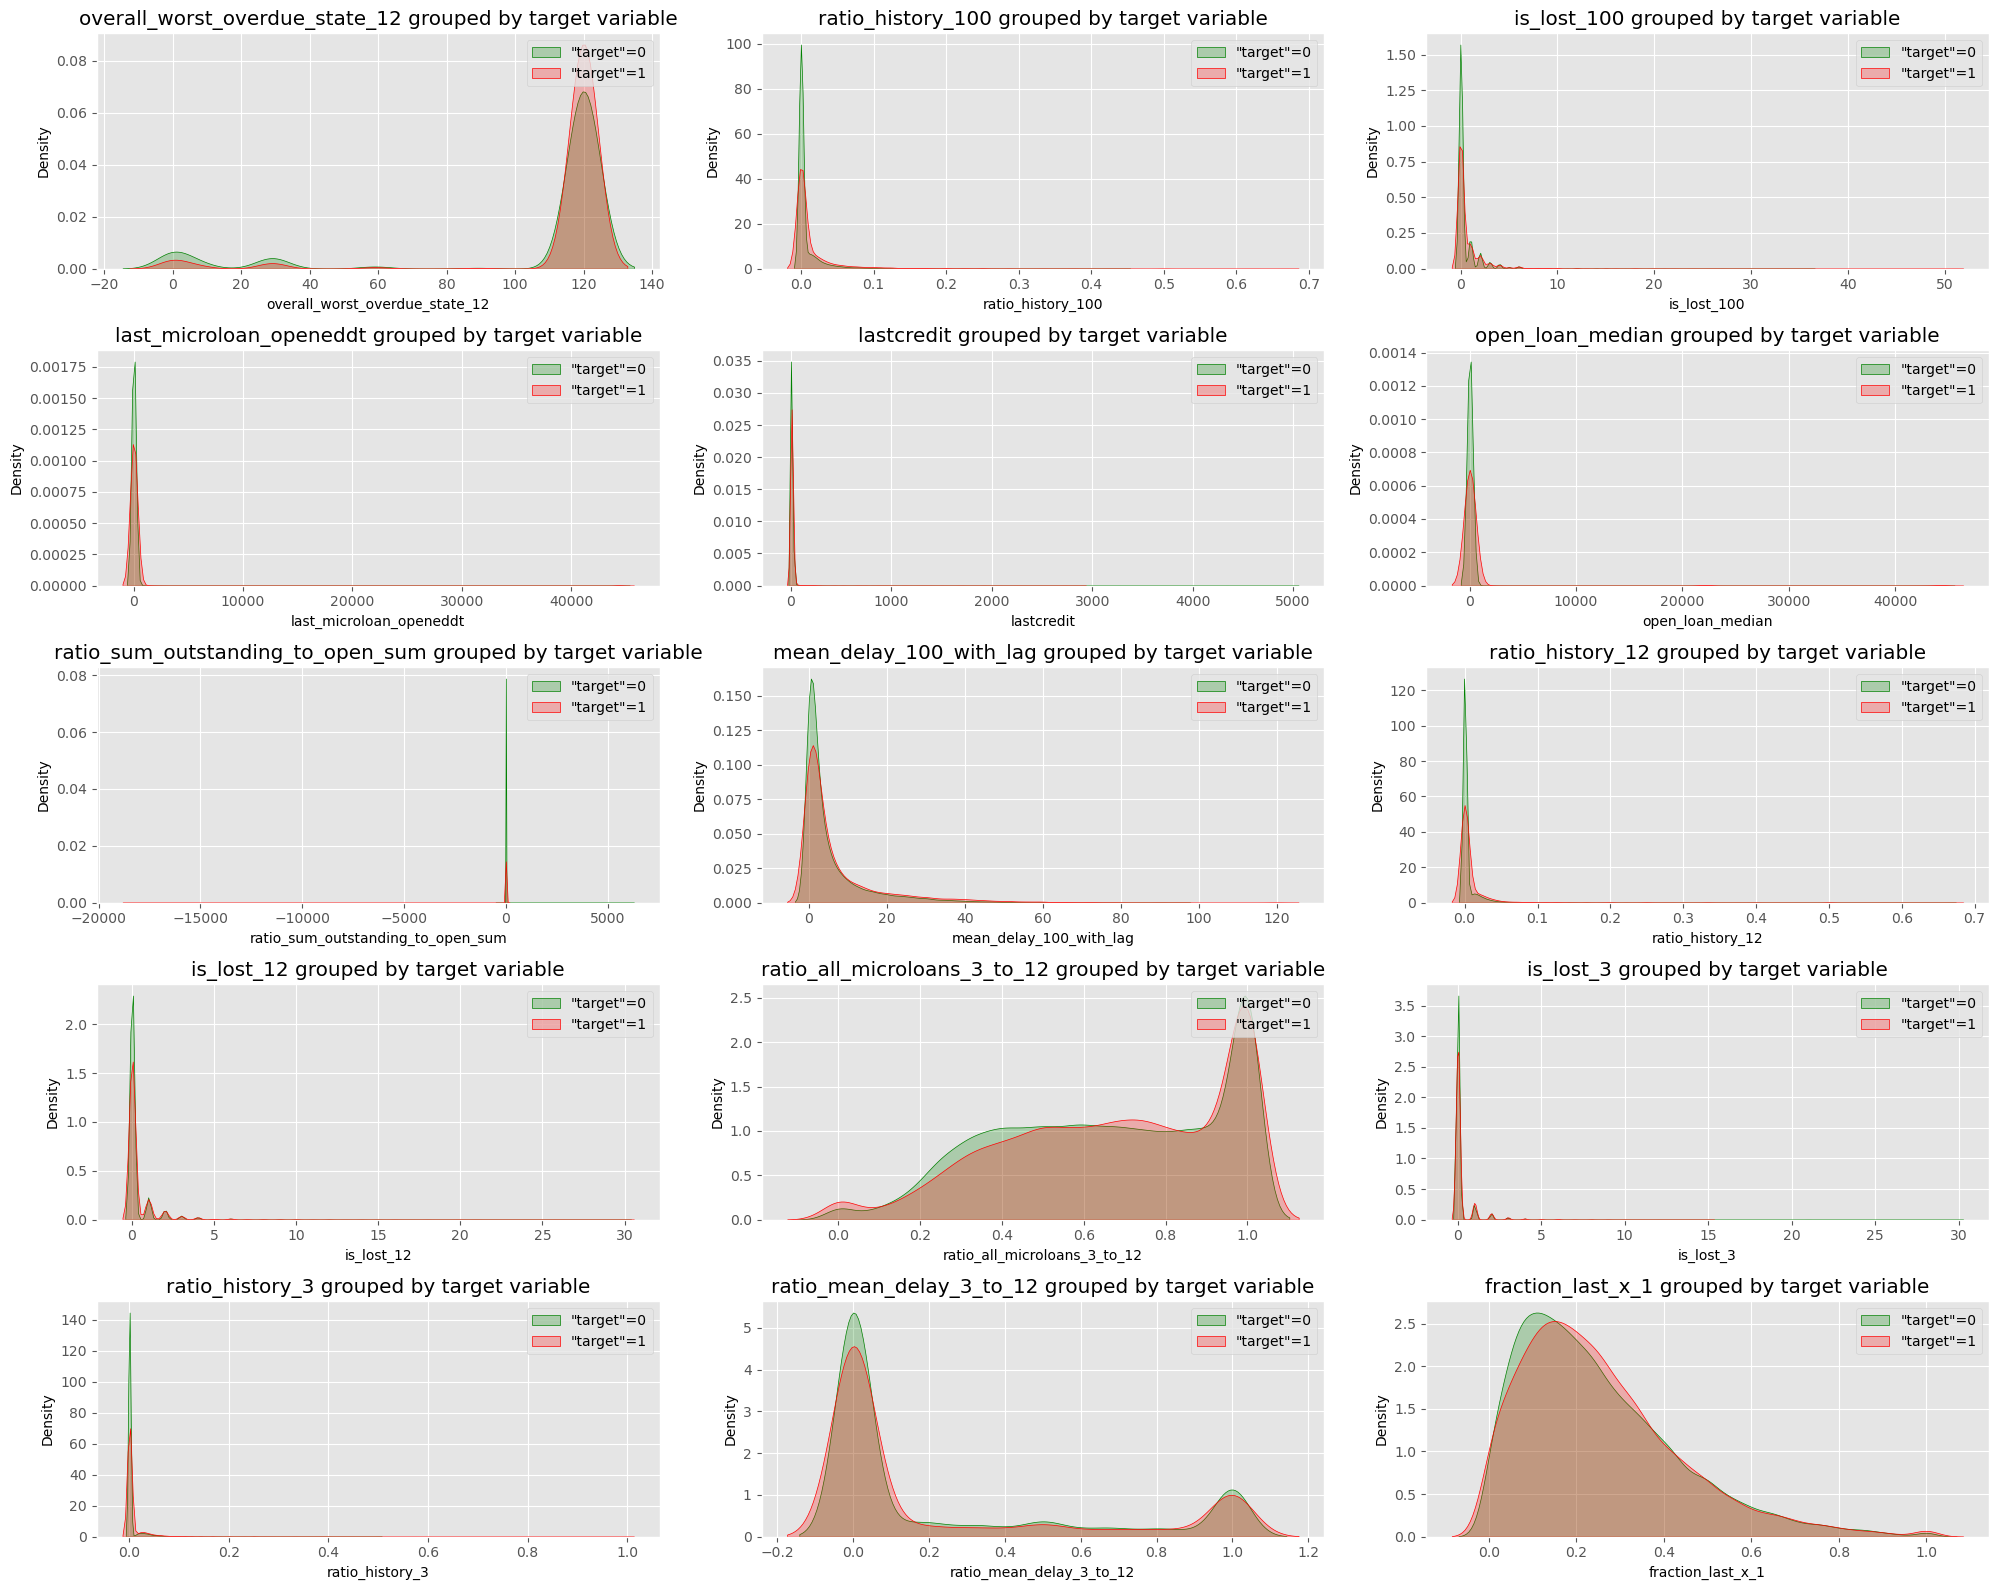

In [297]:
plt.figure(figsize=(20, 16))
for idx, column in enumerate(seps, 1):
    plt.subplot(5, 3, idx)
    feature_with_target_s = data[[column, "target"]]
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s["target"] == 0]
    feature_target_1 = feature_s[feature_with_target_s["target"] == 1]
    sns.kdeplot(feature_target_0, shade=True, label=f'"target"=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label=f'"target"=1', color='r')
    plt.xlabel(column)
    plt.title(f'{column} grouped by target variable')
    plt.legend(loc='best')
plt.tight_layout()
plt.show()
# сильных различий в распределении не видно, это верно и для других признаков (не отрисовано для экономии места)
# сильный скос указывает на выбросы, но ы про них уже знаем (TODO: boxplots)

**клиентский портфель организации - совокупность кредитной задолженности клиентов**

Для поверхностной оценки необходимо оценить:

* Коэффициент покрытия;
* Коэффициент просроченных платежей;
* Коэффициент резервирования;
* Коэффициент доходности.

Имеющихся данных недостаточно, чтобы оценить данные показатели

In [680]:
# data["age_bin"] = pd.cut(data["age"], bins=np.linspace(17, 80, 5), labels=False)

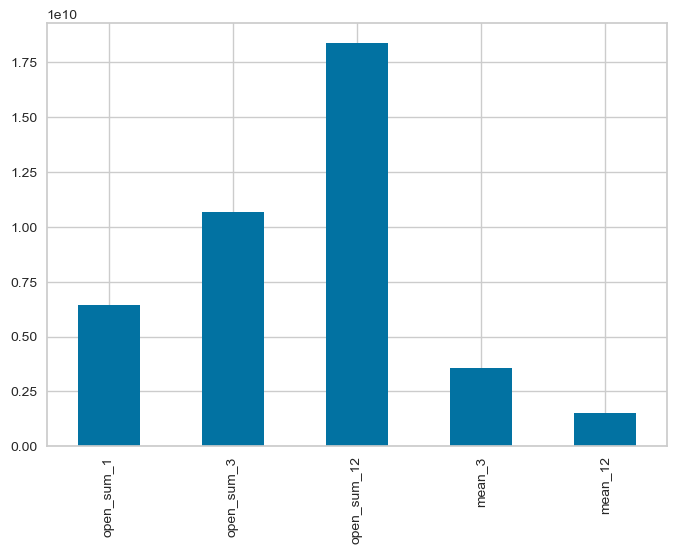

In [728]:
# сумма активного займа (на горизонте 1, 3, 12, среднее за 3, 12 месяцев)
# здесь, правда, не уточняется это сумма остатков по кредитам или общая сумма выданных и еще не погашенных кредитов
mean_3 = data["open_sum_3"].sum()/3
mean_12 = data["open_sum_12"].sum()/12

loans = pd.Series(data=data[["open_sum_1", "open_sum_3", "open_sum_12"]].sum(axis=0).tolist()+[mean_3, mean_12],
                 index=["open_sum_1", "open_sum_3", "open_sum_12", "mean_3", "mean_12"], name="loans")
loans.plot(kind="bar")
plt.show()

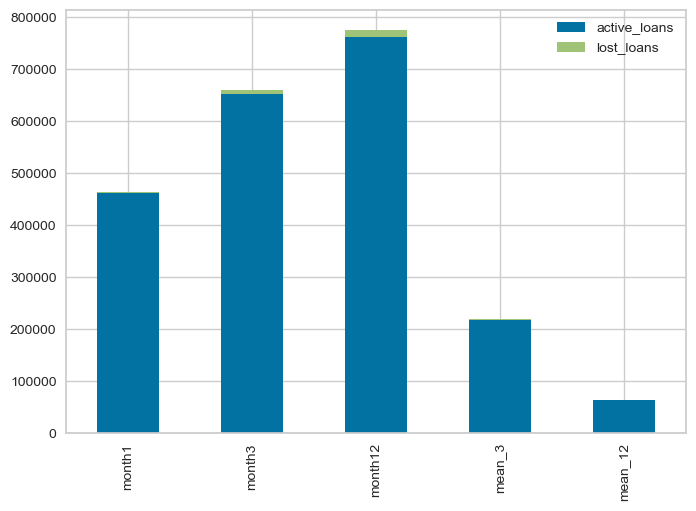

In [738]:
# доля невозвращенных кредитов довольно мала
mean_3 = data["is_active_3"].sum()/3
mean_12 = data["is_active_12"].sum()/12

active_loans = pd.Series(data=data[["is_active_1", "is_active_3", "is_active_12"]].sum(axis=0).tolist()+[mean_3, mean_12],
                 index=["month1", "month3", "month12", "mean_3", "mean_12"], name="active_loans")
mean_3 = data["is_lost_3"].sum()/3
mean_12 = data["is_lost_12"].sum()/12
loans = pd.Series(data=data[["is_lost_1", "is_lost_3", "is_lost_12"]].sum(axis=0).tolist()+[mean_3, mean_12],
                 index=["month1", "month3", "month12", "mean_3", "mean_12"], name="lost_loans")

loans = pd.concat([active_loans, loans], axis=1)

loans.plot(kind="bar", stacked=True)
plt.show()

### Feature Engineering

In [384]:
# трюк, иногда применямый в соревнованиях
X, y = data.drop("target", axis=1)[features], data["target"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed*3)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, stratify=y_valid, random_state=seed*2)

y_train.shape, y_valid.shape, y_test.shape

((33865,), (5080,), (3387,))

In [387]:
cat = CatBoostClassifier(allow_writing_files=False, depth=4, learning_rate=0.05, iterations=500, 
                         use_best_model=True, random_strength=0.15, random_seed=121, 
                         verbose=100, auto_class_weights="SqrtBalanced"
                         ).fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=30)

0:	learn: 0.6885785	test: 0.6886798	best: 0.6886798 (0)	total: 9.64ms	remaining: 4.81s
100:	learn: 0.6302960	test: 0.6377029	best: 0.6377029 (100)	total: 949ms	remaining: 3.75s
200:	learn: 0.6204886	test: 0.6335467	best: 0.6335467 (200)	total: 2s	remaining: 2.98s
300:	learn: 0.6124050	test: 0.6318623	best: 0.6317492 (294)	total: 2.98s	remaining: 1.97s
400:	learn: 0.6055213	test: 0.6312546	best: 0.6312546 (400)	total: 3.98s	remaining: 983ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6308184524
bestIteration = 428

Shrink model to first 429 iterations.


In [389]:
shap_values= cat.get_feature_importance(Pool(x_train, y_train), type="ShapValues")
shap_values = shap_values[:, :-1]

shap_feat = list(x_train.columns[np.argsort(np.abs(shap_values).mean(axis=0))[::-1]])
top_shap_feat = shap_feat[:20]

top_left = [j for i, j in enumerate(top_shap_feat) if i % 2 == 0]
top_right = [j for i, j in enumerate(top_shap_feat) if i % 2 != 0]

In [390]:
top_left, top_right

(['overall_worst_overdue_state_12',
  'is_active_3',
  'is_active_type_micro_3',
  'ratio_history_100',
  'isnt_active_3',
  'open_sum_12',
  'is_active_12',
  'fraction_last_x_1',
  'is_active_1',
  'is_type_consumer_3'],
 ['isnt_active_1',
  'micro_loans_active_100',
  'age',
  'is_type_micro_3',
  'count_all_credits',
  'ratio_history_12',
  'is_type_micro_1',
  'fraction_last_x_3',
  'is_type_credit_card_100',
  'is_type_micro_12'])

In [391]:
for i in range(len(top_left)):
    for j in range(len(top_right)):
        col_name = top_left[i] + "_SUB_" + top_right[j] + "_DIV_" + top_left[i]
        data[col_name] = np.where(((data[top_left[i]] - data[top_right[j]]) == 0) | 
                               (data[top_left[i]] == 0), 0, (data[top_left[i]] - data[top_right[j]]) / data[top_left[i]])

In [393]:
# далеко не исчерпывающий список. Узнаем, даст ли это хоть какой-то буст

data["active100_age"] = data["is_active_100"] / data["age"]
data["lost100_age"] = data["is_lost_100"] / data["age"]

data["lost12_mean"] = data["is_lost_12"] / 12

data["micro_loans_active12_mean"] = data["micro_loans_active_12"] / 12
data["micro_loans_active3_mean"] = data["micro_loans_active_3"] / 3

data["open_sum3_12"] = data["open_sum_3"] / (data["open_sum_12"] / 4)
data["open_sum1_12"] = data["open_sum_1"] / (data["open_sum_12"] / 4)
data["open_sum1_3"] = data["open_sum_1"] / (data["open_sum_3"] / 3)

data["lost_112"] = data["is_lost_1"] / data["is_lost_12"] / 12
data["active_112"] = data["is_active_1"] / data["is_active_12"] / 12

data["consumer_active_100"] = data["is_active_type_consumer_100"] / data["is_active_type_micro_100"]
data["micro_312"] = data["is_type_micro_3"] / data["is_type_micro_12"]
data["micro_113"] = data["is_type_micro_1"] / data["is_type_micro_3"]
data["open_sum_r3"] = data["open_sum_3"] * data["ratio_history_3"]
data["open_sum_r1"] = data["open_sum_1"] * data["ratio_history_1"]
data["open_sum_r12"] = data["open_sum_12"] * data["ratio_history_12"]
data["open_sum_312"] = data["open_sum_3"] * data["ratio_history_3"]  / data["open_sum_12"] * data["ratio_history_12"]

data["active_lost_sd12"] = (data["is_active_12"] - data["is_lost_12"]) / data["is_active_12"]
data["active_lost_sd1"] = (data["is_active_1"] - data["is_lost_1"]) / data["is_active_1"]
data["active_lost_sd3"] = (data["is_active_3"] - data["is_lost_3"]) / data["is_active_3"]

data.fillna(0, inplace=True)
data.replace([-np.inf, np.inf], 0, inplace=True)

In [397]:
# так как не использовали статистики (например, разбиение переменных на бины, на бины с вычислением по ним агрегаций), 
# то можно разбиение на train/test перенести на этап после создания признаков

X, y = data.drop("target", axis=1), data["target"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, stratify=y_valid, random_state=seed)

y_train.shape, y_valid.shape, y_test.shape

((33865,), (5080,), (3387,))

In [398]:
y_train.value_counts(normalize=True)

target
0.0000   0.7230
1.0000   0.2770
Name: proportion, dtype: float64

In [399]:
# adversarial vallidation: проверка близости распределения, 0.5 - модель не различает две выборки
print(check_split_equality(x_train, x_valid))
print(check_split_equality(x_train, x_test))

CV-score, mean: 0.4934, std: 0.0064
CV-score, mean: 0.5027, std: 0.0078


### Feature selection

In [400]:
# RFE: удаляем рекурсивно признаки, основываясь на shap-values
# BorutaShap: создаем shadow-признаки (перемешанные) обучаем модель, у какого важность выше максимальной важности теневого
# тот остается, у кого ниже проводим биномиальный стат. тест: значимо ли различие у тех признаков, у кот. важность ниже
# теневой. Если разница стат. значима - убираем признак и повторяем шаги пока не закончатся итерации либо не раскидаем все 
# признаки
params = {
        "iterations": 400,
        "loss_function": "Logloss",
        "use_best_model": True,
        "thread_count": -1,
        "silent": True,
        "depth": 5,
        "random_seed": seed//5,
        "allow_writing_files": True,
        "boosting_type": "Ordered",
        "learning_rate": 0.03,
        "eval_metric": "Logloss", 
        "custom_metric": ["F1", "AUC"],
}

train_pool = Pool(x_train, y_train, cat_features=None)
valid_pool = Pool(x_valid, y_valid, cat_features=None)

In [402]:
# цель: убрать лишние признаки, шум, задача-минимум - не потерять в качестве, максимум - повысить качество
# shap-values: оценивает вклад признака в предикт (из теории игр) без привязки к конкретному ml алгоритму
def select_features(X_tr, y_tr, X_vl, y_vl, algorithm: EFeaturesSelectionAlgorithm, steps: int = 1, select=110):
    cat_feats = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()
    train_pool = Pool(X_tr, y_tr, cat_features=cat_feats)
    valid_pool = Pool(X_vl, y_vl, cat_features=cat_feats)
    
    model = CatBoostClassifier(**params)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(X_tr.shape[1])),
        num_features_to_select=select,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,  # утверждается, что данный вариант наиболее точный
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    return summary

feature_set = select_features(x_train, y_train, x_valid, y_valid,
                              algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=30)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [404]:
inbuilt = feature_set["selected_features_names"]

In [405]:
bparams = {
        "iterations": 400,
        "loss_function": "Logloss",
        "use_best_model": False,
        "thread_count": -1,
        "silent": True,
        "depth": 5,
        "random_seed": seed,
        "allow_writing_files": True,
        "auto_class_weights": None,
        "boosting_type": "Ordered",
        "learning_rate": 0.03,
}

classifier = CatBoostClassifier(**bparams)
selector = BorutaShap(model=classifier, importance_measure='shap', classification=True)

selector.fit(x_train[inbuilt], 
             y_train, 
             n_trials=50, 
             sample=False, 
             normalize=True, 
             verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

20 attributes confirmed important: ['overall_worst_overdue_state_12', 'overall_worst_overdue_state_12_SUB_age_DIV_overall_worst_overdue_state_12', 'open_sum1_12', 'is_active_type_micro_3_SUB_is_type_micro_3_DIV_is_active_type_micro_3', 'is_active_type_micro_3_SUB_micro_loans_active_100_DIV_is_active_type_micro_3', 'is_active_3_SUB_is_type_micro_12_DIV_is_active_3', 'overall_worst_overdue_state_12_SUB_fraction_last_x_3_DIV_overall_worst_overdue_state_12', 'open_sum_12_SUB_micro_loans_active_100_DIV_open_sum_12', 'ratio_history_12', 'isnt_active_3_SUB_ratio_history_12_DIV_isnt_active_3', 'is_active_3_SUB_is_type_micro_1_DIV_is_active_3', 'open_sum_12_SUB_fraction_last_x_3_DIV_open_sum_12', 'is_active_12_SUB_micro_loans_active_100_DIV_is_active_12', 'is_active_3_SUB_micro_loans_active_100_DIV_is_active_3', 'ratio_history_100', 'open_sum_12_SUB_is_type_micro_3_DIV_open_sum_12', 'is_active_3_SUB_is_type_micro_3_DIV_is_active_3', 'is_active_1_SUB_is_type_micro_1_DIV_is_active_1', 'is_active_

In [406]:
selector.TentativeRoughFix()  

0 tentative features are now accepted: []
16 tentative features are now rejected: ['is_active_type_micro_3_SUB_count_all_credits_DIV_is_active_type_micro_3'
 'is_type_consumer_3_SUB_is_type_micro_3_DIV_is_type_consumer_3'
 'isnt_active_3_SUB_fraction_last_x_3_DIV_isnt_active_3'
 'is_active_1_SUB_micro_loans_active_100_DIV_is_active_1'
 'is_active_type_micro_3_SUB_is_type_credit_card_100_DIV_is_active_type_micro_3'
 'open_sum_312' 'is_active_3_SUB_count_all_credits_DIV_is_active_3'
 'is_type_micro_12'
 'isnt_active_3_SUB_count_all_credits_DIV_isnt_active_3'
 'is_active_12_SUB_is_type_credit_card_100_DIV_is_active_12'
 'is_active_type_micro_3_SUB_is_type_micro_12_DIV_is_active_type_micro_3'
 'ratio_mean_delay_3_to_12'
 'is_type_consumer_3_SUB_is_type_micro_1_DIV_is_type_consumer_3'
 'is_active_12_SUB_is_type_micro_1_DIV_is_active_12'
 'is_active_12_SUB_is_type_micro_3_DIV_is_active_12'
 'isnt_active_3_SUB_age_DIV_isnt_active_3']


In [ ]:
# как альтернативный вариант неплохо работает: средняя важность на кросс-валидации + итеративный рост глубины
# дерева (чем ранее признак получает > 0 важность тем он важнее - раньше привлекается для сплитов в дереве) + 
# важности пересечений принзнаков (под капотом некоторых бустинговых моделей строятся взаимодействия признаков - составные)

In [407]:
selected = [
            'overall_worst_overdue_state_12', 
            'overall_worst_overdue_state_12_SUB_age_DIV_overall_worst_overdue_state_12', 
            'open_sum1_12', 
            'is_active_type_micro_3_SUB_is_type_micro_3_DIV_is_active_type_micro_3', 
            'is_active_type_micro_3_SUB_micro_loans_active_100_DIV_is_active_type_micro_3', 
            'is_active_3_SUB_is_type_micro_12_DIV_is_active_3', 
            'overall_worst_overdue_state_12_SUB_fraction_last_x_3_DIV_overall_worst_overdue_state_12', 
            'open_sum_12_SUB_micro_loans_active_100_DIV_open_sum_12', 
            'ratio_history_12', 
            'isnt_active_3_SUB_ratio_history_12_DIV_isnt_active_3', 
            'is_active_3_SUB_is_type_micro_1_DIV_is_active_3', 
            'open_sum_12_SUB_fraction_last_x_3_DIV_open_sum_12', 
            'is_active_12_SUB_micro_loans_active_100_DIV_is_active_12', 
            'is_active_3_SUB_micro_loans_active_100_DIV_is_active_3', 
            'ratio_history_100', 
            'open_sum_12_SUB_is_type_micro_3_DIV_open_sum_12', 
            'is_active_3_SUB_is_type_micro_3_DIV_is_active_3', 
            'is_active_1_SUB_is_type_micro_1_DIV_is_active_1', 
            'is_active_type_micro_3_SUB_is_type_micro_1_DIV_is_active_type_micro_3', 
            'is_active_1_SUB_is_type_micro_3_DIV_is_active_1'
        ]

### Model Selection

In [ ]:
# очень часто финансовые организации используют Логистическую регрессию в качестве основной модели
# что вполне логично, она отлично интерпретируется с помощью обученных весов
# сейчас задача строгой интерпретации не стоит, логистическая регрессия требует 
# создания признаков с нелинейными взаимосвязями, удаления (обработкой) выбросов, устранения мультиколлинеарности в признаках,
# осознанного заполнения пропусков, масштабирования признаков, кодирования категориальтных признаков 
# (хороший вариант в банковской сфере Weight of Evidence - ln(p_cat_1/p_cat_0))
# поэтому остановимся на модели градиентного бустинга, которая не требует масштабирования, удаления выбросов, да и 
# заполнения пропусков, под капотом обрабатывает категориальные признаки (catboost - упорядоченный target-encoding)

In [ ]:
# метрики смотрим roc_auc, f1, gini = 2*roc_auc-1
# f1 - следим за соблюдением баланса precision/recall - как часто неверно классифицируем
# roc_auc - дискриминирующая способность модели - веронятность проранжировать случайно выбранный положительный класс выше,
# чем случайно выбранный отризацтельный класс (безотноситльено порога классификации)
# Gini - отражает способоность модели разделять хороших и плохих заемщиков

In [434]:
# пока практически полностью default параметры обучения
params = {
        "iterations": 1000,  # количество деревьев, важнейший параметр, настраивается один из первых
        "loss_function": "Logloss",  # loss = - sum_i(y(p_i) + (1 - y)log(1 - p_i))
        "use_best_model": True,  # оставит количество деревьев для минимального eval_metric
        "thread_count": -1,  # макс. количество потоков
        "verbose": 100,  
        "random_seed": seed,
        "allow_writing_files": True,  # не будем записывать историю обучения
        "depth": 5,  # глубина дерева, опрделет сложность базового алгоритма 
        "random_strength": 1,  # дисперсия случайной добавки в скор-функцию, максимизируемой при поиске сплита - стабилизирует обучение, хорошее значени часто 0.15
        "rsm": 1,  # доля случайно выбранных признаков на каждом уровне дерева, для регуляризации
        "boosting_type": "Ordered",  # упорядоченный: использует виртуальные logN моделей в каждом дереве для имитации вычисления значений в дистах на примерах, не участвовавших в обучении - минимизирует prediction shift, работает дольше Plain
        "border_count": 254,  # максисмальное количество бинов при разбиении вещественного признака speed/accuracy tradeoff, использует greedyLogSum - выбросы практически не влияют на зачения порогов бинов
        # "bagging_temperature": 1,  # сэмплим веса для образцов из гамма-распределения, работает с Bayesian boostrap_type, формула веса -log(phi)^t, phi - uniform[0,1], t - наш bagging_temp, 0 - Bernuolli, регуляризирует 
        "score_function": "Cosine",  # формула для скор функции, косинус - x1.dot(x2) / (|x1|*|x2|), рекомендуется для Ordered
        "grow_policy": "SymmetricTree", # деревья симметричные - на каждом уровне одинаковое условие всех сплитов, скор функция максимизируется по всем узлам (сумма). В случае Lossguide - можно выставить макс. глубину и ограничивать кол-во листьев
        "auto_class_weights": "SqrtBalanced",  # штраф при неверной классификации миоритарного класса
        "l2_leaf_reg": 3,  # регуляризация в листе, чем выше тем позже переобучение, sum(grad) / (sum(hess) + l2_leaf_reg)
        "learning_rate": 0.03,  # важнейший параметр, настраивается один из первых, по факту доля дерева в общем предикте, чем ниже, тем дольше учится и нужно больше деревьев, но при этом снижает влияние неадекватных деревьев
        "bootstrap_type": "MVS",  # выбираем "subsample" образцов с максимальными градиентами, с которыми модель плохо справляется, остальные с вероятностью |gi|/mu, mu - порог по которому определяем большие градиенты, маленькие градиенты не берем - и  так справляемся
        "subsample": 0.8,
        #"max_ctr_complexity": 2,  # сколько переменных (количество interactions) создавать из категориальных в процессе обучения
        "nan_mode" : "Min",  # заменить пропуски значением вне диапазона признака, гарантирует его выделение в отдельный лист при сплите
        "eval_metric": "Logloss",  # выбор recall тк модели не удается найти достаточную для решения задачи долю "плохих" клиентов
        "custom_metric": ["F1", "Recall", "AUC"], # можно ориентировать обучение на AUC - так как метрику будем оценивать Gini = 2*AUC - 1 
}

In [413]:
train_pool = Pool(x_train[selected], y_train, cat_features=None)  # cat_features: берем в расчет наблюдения до текущей позиции - полжительный класс в категории + prior=0.05 / положительный класс + 1 (пермешиваем несколько раз, берем один вариант, на инференсе берем статистики из обучающего набора)
valid_pool = Pool(x_valid[selected], y_valid, cat_features=None)

In [435]:
baseline = CatBoostClassifier(**params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)

0:	learn: 0.6900899	test: 0.6902659	best: 0.6902659 (0)	total: 40.3ms	remaining: 40.2s
100:	learn: 0.6329707	test: 0.6386691	best: 0.6386691 (100)	total: 4.29s	remaining: 38.2s
200:	learn: 0.6281911	test: 0.6361167	best: 0.6361167 (200)	total: 8.78s	remaining: 34.9s
300:	learn: 0.6255021	test: 0.6354228	best: 0.6354228 (300)	total: 13.4s	remaining: 31.1s
400:	learn: 0.6229610	test: 0.6350509	best: 0.6350417 (391)	total: 18.2s	remaining: 27.2s
500:	learn: 0.6199056	test: 0.6349902	best: 0.6348916 (471)	total: 23.1s	remaining: 23s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6348916486
bestIteration = 471

Shrink model to first 472 iterations.


In [436]:
y_train_pred = baseline.predict_proba(train_pool)[:, 1]
y_test_pred = baseline.predict_proba(x_test)[:, 1]

In [437]:
print(classification_report(y_train, y_train_pred >= 0.5 , digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred >= 0.5, digits=4))

              precision    recall  f1-score   support

         0.0     0.7564    0.9131    0.8274     24483
         1.0     0.5064    0.2326    0.3187      9382

    accuracy                         0.7246     33865
   macro avg     0.6314    0.5728    0.5731     33865
weighted avg     0.6871    0.7246    0.6865     33865

------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.7506    0.9094    0.8224      2449
         1.0     0.4714    0.2111    0.2916       938

    accuracy                         0.7160      3387
   macro avg     0.6110    0.5602    0.5570      3387
weighted avg     0.6733    0.7160    0.6754      3387



In [462]:
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"train: {roc_auc_train:.6f}, test: {roc_auc_test:.6f}")
print(f"Test GINI: {(2*roc_auc_train-1):.6f}, test: {(2*roc_auc_test-1):.6f}")

train: 0.673120, test: 0.663653
Test GINI: 0.346241, test: 0.327305


Normalized confusion matrix


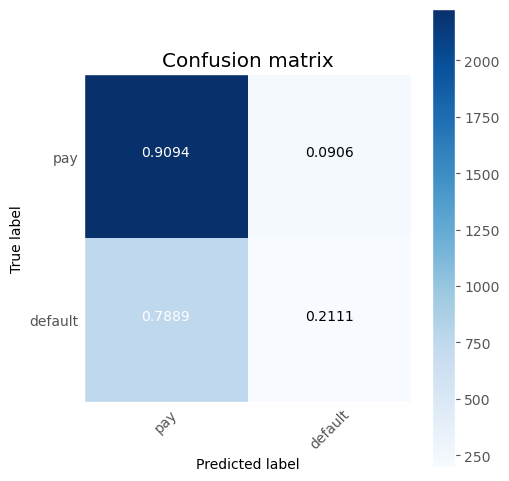

In [439]:
plot_confusion_matrix(y_test, y_test_pred >= 0.5, classes=["pay", "default"], normalize=True)

# TP - модель находит % из всех клиентов, просрочивших кредит
# TN - модель одобрила % заявок клиентам, вернувшим кредит
# FP - модель не выдала % заявок хорошим клиентам
# FN - модель не нашла (одобрила) % клиентов, не выполнивших обязательства

Confusion matrix, without normalization


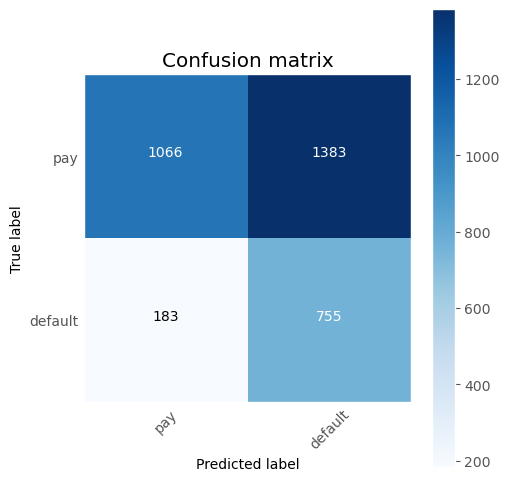

In [446]:
# бейзлайн с таким порогом соответствует условию задачи
plot_confusion_matrix(y_test, y_test_pred >= 0.335, classes=["pay", "default"], normalize=False)

In [441]:
# выбрать порог классификации (при необходимости также можно откалибровать вероятность: CalibratedlassifierCV)

def calc_best_t(y_true, scores, t=100, verbose=False):
    metrics = []
    ts = np.linspace(0.05, 0.95, t)
    total = len(y_true)
    for e in ts:
        cm = confusion_matrix(y_true, scores>=e)
        tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        approved = tn + fn
        app_perc = approved / total
        faults = fn / approved
        if faults < 0.15 and app_perc > 0.35:
            metrics.append((e, faults, app_perc))
        if verbose:
            print(round(e*100, 4), round(faults*100, 4), round(app_perc*100, 2))
    return metrics

In [442]:
calc_best_t(y_test, y_test_pred, t=200, verbose=False)

[(0.3304020100502512, 0.1443894389438944, 0.35783879539415414),
 (0.33492462311557786, 0.1466346153846154, 0.36846767050487156),
 (0.3394472361809045, 0.14926527455529776, 0.38175376439326836)]

In [649]:
from sklearn.calibration import CalibratedClassifierCV

clf = CalibratedClassifierCV(estimator=baseline, method='sigmoid', cv="prefit").fit(x_valid[selected], y_valid)

Confusion matrix, without normalization


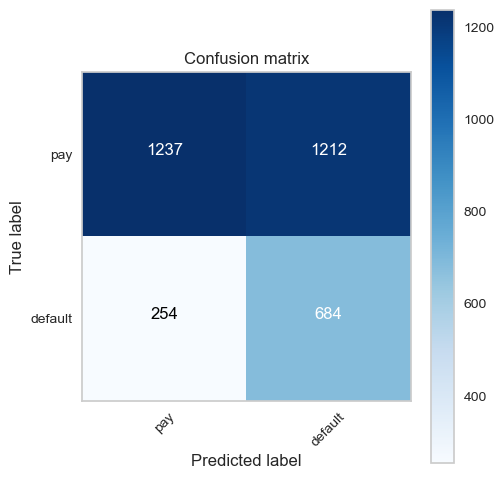

In [650]:
# бейзлайн с таким порогом соответствует условию задачи
# много FP - будем чаще отклонять хороших клиентов
plot_confusion_matrix(y_test, clf.predict_proba(x_test[selected])[:,1] >= 0.25, classes=["pay", "default"], normalize=False)

In [651]:
calc_best_t(y_test, clf.predict_proba(x_test[selected])[:,1], t=200, verbose=False)

[(0.22638190954773868, 0.14321192052980133, 0.3566578092707411),
 (0.23090452261306532, 0.14616613418530353, 0.3696486566282846),
 (0.23542713567839196, 0.14885496183206107, 0.38677295541777384)]

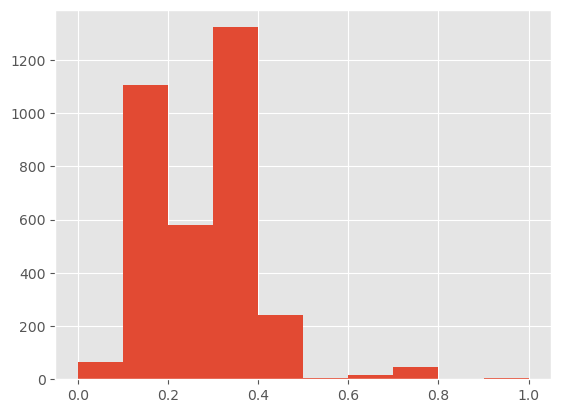

In [456]:
plt.hist(clf.predict_proba(x_test[selected])[:,1])
plt.show()

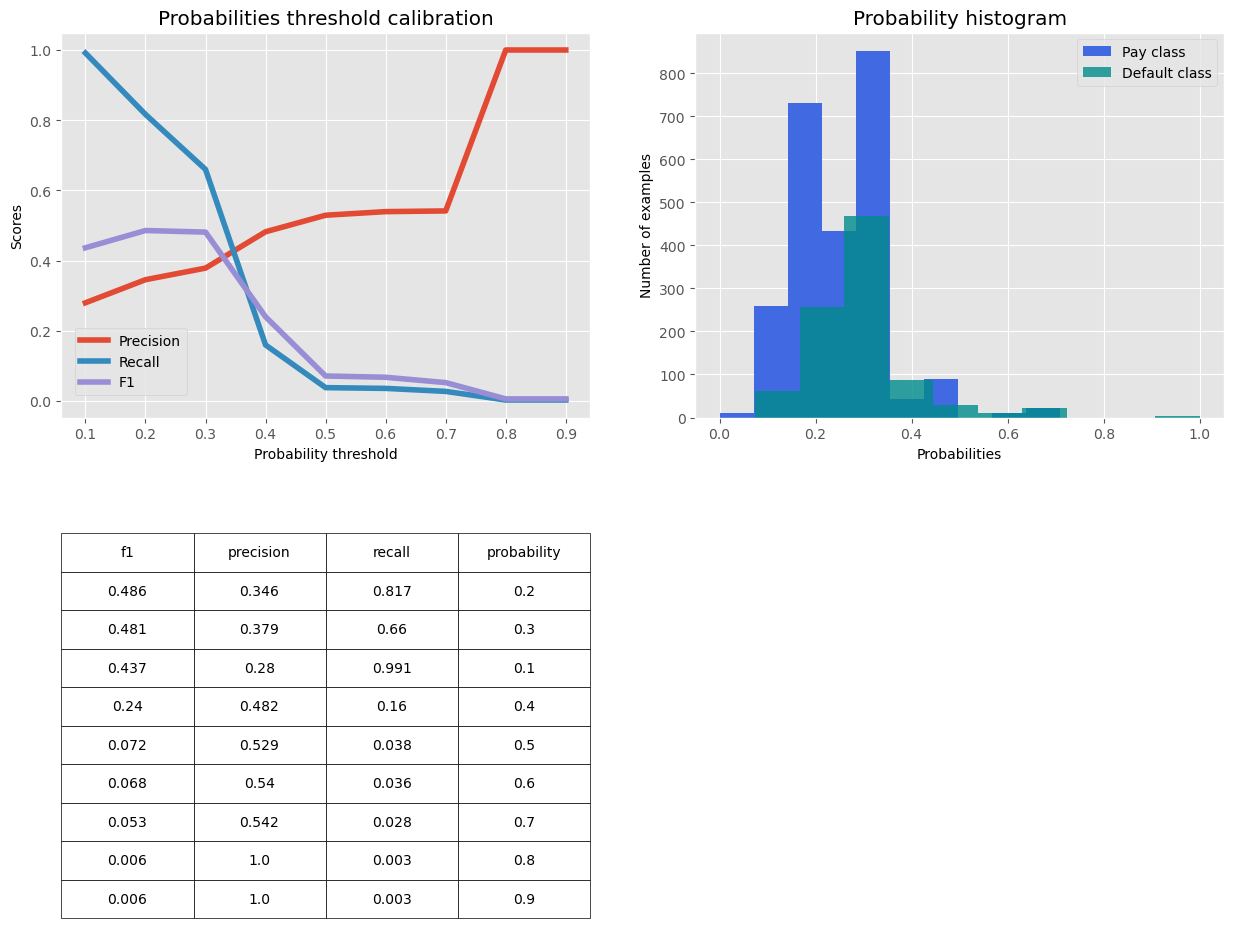

In [486]:
show_proba_calibration_plots(clf.predict_proba(x_test[selected])[:,1], y_test, average='binary')

In [463]:
x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)

In [477]:
params.update({"silent": True})
params.pop("verbose")

False

In [481]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=111)

_, oof_preds, _ = catboost_cross_validation(x_train_val[selected].reset_index(drop=True), 
                                            y_train_val.reset_index(drop=True), 
                                            params=params, 
                                            rounds=40, 
                                            cv=cv, 
                                            score_fn=roc_auc_score,
                                            calculate_ci=True, 
                                            categorical=None,
                                            textual=None,
                                            preprocess=None,
                                            best_iter="mean",
                                            check_equality=True,
                                            seed=42)

Wed Jul 19 02:58:17 2023, Cross-Validation, 38945 rows, 20 cols
Estimating best number of trees.
Evaluating cross validation with 352 trees.
Split check on number of tree estimation:  0.5012  +/-  0.0155
Fold 1, Train score = 0.66585, Valid score = 0.64617
Fold 2, Train score = 0.66517, Valid score = 0.65110
Fold 3, Train score = 0.66663, Valid score = 0.64476
Fold 4, Train score = 0.66521, Valid score = 0.64236
Fold 5, Train score = 0.66434, Valid score = 0.65131
Fold 6, Train score = 0.66060, Valid score = 0.64503
Fold 7, Train score = 0.66494, Valid score = 0.64008
Split check while cross-validating:  0.4982  +/-  0.0118
Train score by each fold: [0.66585, 0.66517, 0.66663, 0.66521, 0.66434, 0.6606, 0.66494]
Valid score by each fold: [0.64617, 0.6511, 0.64476, 0.64236, 0.65131, 0.64503, 0.64008]
Train mean score by each fold:0.66468 +/- 0.00179
Valid mean score by each fold:0.64583 +/- 0.00387
**************************************************
OOF-score roc_auc_score: 0.64579
Expect

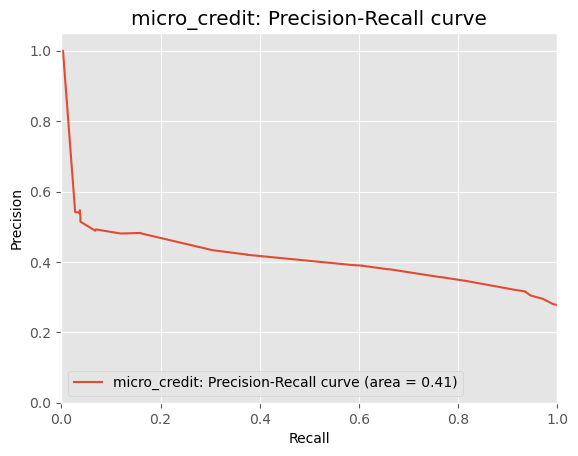

In [484]:
plot_precision_recall_curve(y_test, clf.predict_proba(x_test[selected])[:,1], model_name="micro_credit")

### Попробуем использовать второй набор

In [489]:
coltoadd = [col for col in selected if not col in features]

In [490]:
# хотя нам и неизвестно погасили бы кредит заемщики из вотрого набора, но необходимо как то спользовать эту информацию
# попробуем найти максимально похожих на них (факт неодобрения им кредита важен)

canc = pd.read_csv("reject.csv", index_col="Unnamed: 0")
canc = check_duplicates_and_constants(canc)

canc["close_loan_median"].fillna(99999, inplace=True)
canc["open_loan_median"].fillna(0, inplace=True)
canc.replace([-np.inf, np.inf], 0, inplace=True)

# дополняем недостающими признаками
canc["open_sum1_12"] = canc["open_sum_1"] / (canc["open_sum_12"] / 4)
for i in range(len(top_left)):
    for j in range(len(top_right)):
        col_name = top_left[i] + "_SUB_" + top_right[j] + "_DIV_" + top_left[i]
        canc[col_name] = np.where(((canc[top_left[i]] - canc[top_right[j]]) == 0) | 
                               (canc[top_left[i]] == 0), 0, (canc[top_left[i]] - canc[top_right[j]]) / canc[top_left[i]])


data_conc = pd.concat([x_train[selected], canc[selected]], axis=0).sample(frac=1)

Initial train shape: (106511, 73)
Duplicates in train: 205
overdue_loans_12 in train set is constant, removed from train set.
overdue_loans_3 in train set is constant, removed from train set.
ratio_overdue_loans_3_to_12 in train set is constant, removed from train set.
Final train shape: (106306, 70) 

In [528]:
data_conc.fillna(0, inplace=True)
data_conc.replace([-np.inf, np.inf], 0, inplace=True)

In [521]:
# логарифмирование или виндзоризация (для валидационной и тестовой выборок также отдельно)
#  - log1p
colstolog = data_conc.columns.str.contains("is_type_micro_3|is_type_micro_12|micro_loans_active_100")
colstolog = data_conc.columns[colstolog]

# отложим пока. 

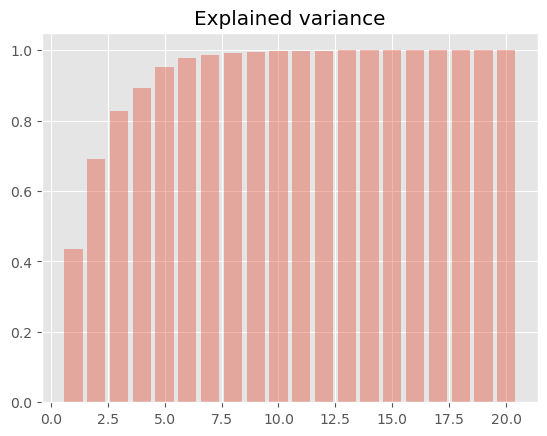

In [530]:
pre_pipe = make_pipeline(MinMaxScaler(), PCA(n_components=None, random_state=seed))
pca_factors = pre_pipe.fit_transform(data_conc)
pca_features = pd.DataFrame(data=pca_factors, columns=[f"pca_{i}" for i in range(1, data_conc.shape[1]+1)], 
                            index=data_conc.index)
plt.title("Explained variance")
plt.bar(np.arange(1, data_conc.shape[1]+1), pre_pipe[1].explained_variance_ratio_.cumsum(), alpha=0.4)
plt.show()

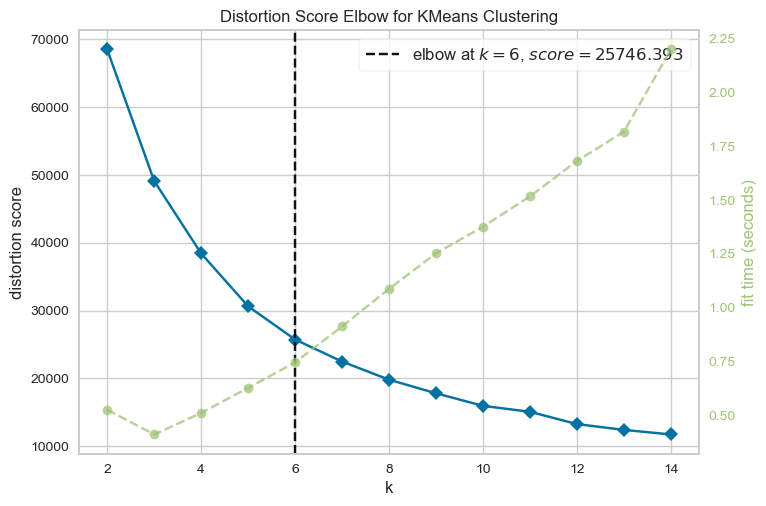

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [533]:
from yellowbrick.cluster import KElbowVisualizer

pre_pipe = make_pipeline(MinMaxScaler(), PCA(n_components=16, random_state=seed))
data_conc_scaled = pre_pipe.fit_transform(data_conc)
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 15))

visualizer.fit(data_conc_scaled) 
visualizer.show()

In [538]:
pipe = make_pipeline(
                MinMaxScaler(), # приводим признаки к одному масштабу, важно для алгоритма, используещего евклидово расстояние
                PCA(n_components=16, random_state=seed),  # снижаем размерность (при большой точки становятся практически равнудаленнми друг от друга, устраняем шум и ненужные кореляции)
                KMeans(n_clusters=6, random_state=42)  # распределяем образцы по кластерам
    ).fit(data_conc)

In [542]:
# используем номер кластера как признак (если будет буст - можем добавить расстояние до центроидов, ближайшего соседа)
x_train["cluster"] = pipe.predict(x_train[selected])
x_valid["cluster"] = pipe.predict(x_valid[selected])
x_test["cluster"] = pipe.predict(x_test[selected])

train_pool = Pool(x_train[selected + ["cluster"]], y_train, cat_features=None)
valid_pool = Pool(x_valid[selected +["cluster"]], y_valid, cat_features=None)

In [584]:
# params.pop("silent")
# params.update({"verbose": 100})
params = {'iterations': 500,
         'loss_function': 'Logloss',
         'use_best_model': True,
         'thread_count': -1,
         'random_seed': 123,
         'allow_writing_files': True,
         'depth': 5,
         'random_strength': 2,
         'rsm': 0.95,
         'boosting_type': 'Ordered',
         'border_count': 254,
         'score_function': 'Cosine',
         'grow_policy': 'SymmetricTree',
         'auto_class_weights': 'Balanced',
         'l2_leaf_reg': 3,
         'learning_rate': 0.03,
         'bootstrap_type': 'Bayesian',
         'bagging_temperature': 0.5,
         #'subsample': 0.8,
         'nan_mode': 'Min',
         'eval_metric': 'Logloss',
         'custom_metric': ['F1', 'Recall', 'AUC'],
         'verbose': 100}

In [585]:
# обучаем модель еще раз с новым признаком (проверяем также балансировку классов)
baseline2 = CatBoostClassifier(**params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)

0:	learn: 0.6917658	test: 0.6919654	best: 0.6919654 (0)	total: 38.8ms	remaining: 19.3s
100:	learn: 0.6590417	test: 0.6650947	best: 0.6650947 (100)	total: 4.13s	remaining: 16.3s
200:	learn: 0.6536834	test: 0.6626561	best: 0.6626561 (200)	total: 8.42s	remaining: 12.5s
300:	learn: 0.6504839	test: 0.6620962	best: 0.6620771 (298)	total: 12.8s	remaining: 8.48s
400:	learn: 0.6477381	test: 0.6617530	best: 0.6617494 (399)	total: 17.2s	remaining: 4.26s
499:	learn: 0.6453090	test: 0.6614342	best: 0.6614338 (497)	total: 21.5s	remaining: 0us

bestTest = 0.6614337619
bestIteration = 497

Shrink model to first 498 iterations.


In [586]:
y_train_pred2 = baseline2.predict_proba(train_pool)[:, 1]
y_test_pred2 = baseline2.predict_proba(x_test[selected + ["cluster"]])[:, 1]

In [587]:
# проверяем
print(classification_report(y_train, y_train_pred2 >= 0.5 , digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred2 >= 0.5, digits=4))

              precision    recall  f1-score   support

         0.0     0.8132    0.6000    0.6906     24483
         1.0     0.3803    0.6404    0.4772      9382

    accuracy                         0.6112     33865
   macro avg     0.5967    0.6202    0.5839     33865
weighted avg     0.6933    0.6112    0.6314     33865

------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8180    0.5982    0.6910      2449
         1.0     0.3835    0.6525    0.4830       938

    accuracy                         0.6132      3387
   macro avg     0.6007    0.6253    0.5870      3387
weighted avg     0.6976    0.6132    0.6334      3387



Confusion matrix, without normalization


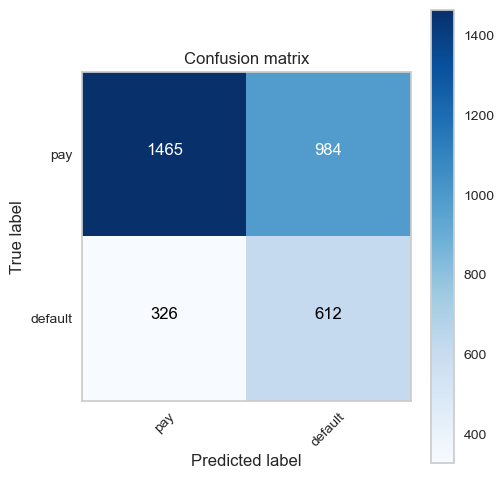

In [591]:
plot_confusion_matrix(y_test, y_test_pred2 >= 0.5, classes=["pay", "default"], normalize=False)

In [599]:
clf2 = CalibratedClassifierCV(estimator=baseline2, method='isotonic', cv="prefit").fit(x_valid[selected+["cluster"]], y_valid)

Confusion matrix, without normalization


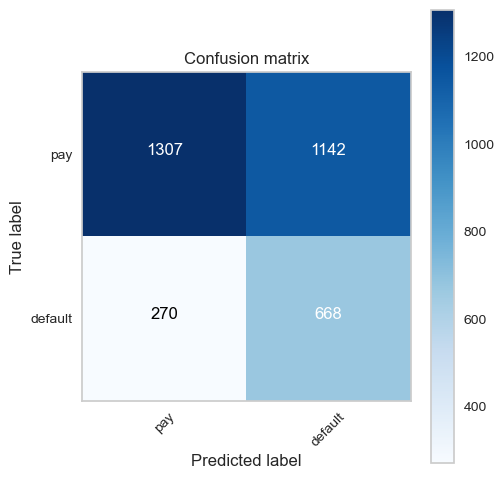

In [606]:
plot_confusion_matrix(y_test, clf2.predict_proba(x_test[selected+["cluster"]])[:,1] >= 0.28, classes=["pay", "default"], normalize=False)

In [652]:
calc_best_t(y_test, clf2.predict_proba(x_test[selected + ["cluster"]])[:,1], t=200, verbose=False)

[(0.20829145728643217, 0.1478405315614618, 0.35547682314732804),
 (0.2128140703517588, 0.1478405315614618, 0.35547682314732804),
 (0.2173366834170854, 0.14771784232365145, 0.35577206967818126),
 (0.22185929648241204, 0.14771784232365145, 0.35577206967818126),
 (0.22638190954773868, 0.14771784232365145, 0.35577206967818126),
 (0.23090452261306532, 0.14771784232365145, 0.35577206967818126),
 (0.23542713567839196, 0.14771784232365145, 0.35577206967818126)]

In [613]:
params.update({"silent": True})
params.pop("verbose")

100

In [614]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=112)
x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)

_, oof_preds, _ = catboost_cross_validation(x_train_val[selected + ["cluster"]].reset_index(drop=True), 
                                            y_train_val.reset_index(drop=True), 
                                            params=params, 
                                            rounds=40, 
                                            cv=cv, 
                                            score_fn=roc_auc_score,
                                            calculate_ci=True, 
                                            categorical=None,
                                            textual=None,
                                            preprocess=None,
                                            best_iter="mean",
                                            check_equality=True,
                                            seed=42)  # не супер стадильная модель, но в целом можно применить

Wed Jul 19 10:30:10 2023, Cross-Validation, 38945 rows, 21 cols
Estimating best number of trees.
Evaluating cross validation with 392 trees.
Split check on number of tree estimation:  0.498  +/-  0.0124
Fold 1, Train score = 0.66796, Valid score = 0.64405
Fold 2, Train score = 0.66576, Valid score = 0.65279
Fold 3, Train score = 0.66633, Valid score = 0.64470
Fold 4, Train score = 0.66736, Valid score = 0.64489
Fold 5, Train score = 0.66688, Valid score = 0.65290
Fold 6, Train score = 0.66390, Valid score = 0.64543
Fold 7, Train score = 0.66743, Valid score = 0.64090
Split check while cross-validating:  0.5007  +/-  0.0136
Train score by each fold: [0.66796, 0.66576, 0.66633, 0.66736, 0.66688, 0.6639, 0.66743]
Valid score by each fold: [0.64405, 0.65279, 0.6447, 0.64489, 0.6529, 0.64543, 0.6409]
Train mean score by each fold:0.66652 +/- 0.00127
Valid mean score by each fold:0.64652 +/- 0.00422
**************************************************
OOF-score roc_auc_score: 0.64645
Expected 

In [609]:
pred1 = (clf.predict_proba(x_test[selected])[:,1] >= 0.3).astype(np.uint8)
pred2 = (clf2.predict_proba(x_test[selected+["cluster"]])[:,1] >= 0.28).astype(np.uint8)

In [610]:
# сравним baseline / baseline2
compare_models([pred1, pred2], 
               y_test, 
               f1_score, 
               len(y_train), 
               len(y_test), 
               rope_interval=[-0.01, 0.01],
               model_names=["model1", "model2"],
               sample=0)
# для f1_score статистически значимой разницы между моделями нет

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,model1,model2,-0.7760,0.2190,0.1296,0.0037,0.8666,-0.0144,0.0062,-7.7992,0.0000


In [611]:
pred1 = clf.predict_proba(x_test[selected])[:,1]
pred2 = clf2.predict_proba(x_test[selected+["cluster"]])[:,1]

compare_models([pred1, pred2], 
               y_test, 
               roc_auc_score, 
               len(y_train), 
               len(y_test), 
               rope_interval=[-0.01, 0.01],
               model_names=["model1", "model2"],
               sample=0)
# для roc_auc_score статистически значимой разницы между моделями нет

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,model1,model2,-0.2571,0.3986,0.0272,0.0074,0.9654,-0.0102,0.0078,-2.5839,0.0099


In [ ]:
# остановимся тогда на первой, данные для нее легче готовить (можно дообучить модель на всем наборе)
# скорее всего станет точнее, но проверить сможем только на исторических данных, тк используем весь набор
# Тогда use_best_model=False, iterations ~ 1.05-1.1*best_iter из CV

### Parameter Tuning

In [621]:
# TPE optuna: как и в байесовской оптимизации на каждой итерации алгоритма (строится дерево с параметрами) сэмплится
# набор гиперпараметров, решающий задачу exploration/exploitation (max EI(x) = l(x)/g(x)), 
# исходя из ранее полученной информации с предыдущими параметрами

start_params = {
        "iterations": 500,
        "loss_function": "Logloss",
        "use_best_model": True,
        "thread_count": -1,
        "silent": True,
        "random_seed": seed*5,
        "allow_writing_files": False,
        "boosting_type": "Ordered",
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": None,
        "bootstrap_type": "MVS",
        "eval_metric": "Logloss", 
        "early_stopping_rounds": 40,
        "learning_rate": 0.03,
}

def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 8),
                    'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 30, step=1),
                    'border_count': trial.suggest_int('border_count', 64, 254, step=16),
                    'rsm': trial.suggest_float('rsm', 0.8, 1, step=0.1),
                    'random_strength': trial.suggest_float('random_strength', 0.1, 3, step=0.05),
                    'subsample': trial.suggest_float('subsample', 0.6, 1, step=0.05),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ["Balanced", "SqrtBalanced"])
                    }
    
    param_trials.update(start_params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=431)
    
    scores = []
    for train_idx, valid_idx in cv.split(x_train_val[selected], y_train_val):
        x_tr = x_train_val.iloc[train_idx][selected]
        x_val = x_train_val.iloc[valid_idx][selected]
        y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]
        
        opt_model = CatBoostClassifier(**param_trials).fit(x_tr, y_tr, eval_set=[(x_val, y_val),],)
        pred = opt_model.predict(x_val)
        score = f1_score(y_val, pred, average='macro')  # macro не будет учитывать дисбаланс, оба класса одинаково важны
        scores.append(score)

    return np.mean(scores) - np.std(scores)

In [623]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")  
study.optimize(objective, n_trials=100, timeout=12000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)  # можно поискать еще раз, так как часть параметров лежат на границе выбранных для поиска диапазонах

Number of completed trials: 70
Best trial
Best score: 0.4735161236246035
Best params
{'auto_class_weights': 'Balanced',
 'border_count': 64,
 'depth': 8,
 'l2_leaf_reg': 23,
 'random_strength': 2.1500000000000004,
 'rsm': 0.8,
 'subsample': 0.95}


In [626]:
best_params = {
        "iterations": 500,
        "loss_function": "Logloss",
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": seed*5,
        "allow_writing_files": False,
        "boosting_type": "Ordered",
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "auto_class_weights": None,
        "bootstrap_type": "MVS",
        "eval_metric": "Logloss", 
        "early_stopping_rounds": 40,
        "learning_rate": 0.03,
        'auto_class_weights': 'Balanced',
        'border_count': 64,
        'depth': 8,
        'l2_leaf_reg': 23,
        'random_strength': 2.15,
        'rsm': 0.8,
        'subsample': 0.95,
}

# в идеале лучше переразбить data с новым seed
train_pool = Pool(x_train[selected], y_train, cat_features=None)
valid_pool = Pool(x_valid[selected], y_valid, cat_features=None)

In [627]:
baseline3 = CatBoostClassifier(**best_params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)

0:	learn: 0.6916660	test: 0.6917864	best: 0.6917864 (0)	total: 59.5ms	remaining: 29.7s
100:	learn: 0.6508827	test: 0.6630967	best: 0.6630967 (100)	total: 7.23s	remaining: 28.6s
200:	learn: 0.6416960	test: 0.6617663	best: 0.6617024 (186)	total: 16s	remaining: 23.7s
300:	learn: 0.6346589	test: 0.6614821	best: 0.6614154 (288)	total: 23.6s	remaining: 15.6s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6613933893
bestIteration = 307

Shrink model to first 308 iterations.


In [628]:
y_train_pred3 = baseline3.predict_proba(train_pool)[:, 1]
y_test_pred3 = baseline3.predict_proba(x_test)[:, 1]

In [629]:
print(classification_report(y_train, y_train_pred3 >= 0.5 , digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred3 >= 0.5, digits=4))

              precision    recall  f1-score   support

         0.0     0.8244    0.6106    0.7016     24483
         1.0     0.3939    0.6605    0.4935      9382

    accuracy                         0.6244     33865
   macro avg     0.6091    0.6356    0.5975     33865
weighted avg     0.7051    0.6244    0.6439     33865

------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8133    0.5978    0.6891      2449
         1.0     0.3793    0.6418    0.4768       938

    accuracy                         0.6100      3387
   macro avg     0.5963    0.6198    0.5830      3387
weighted avg     0.6931    0.6100    0.6303      3387



In [630]:
roc_auc_train = roc_auc_score(y_train, y_train_pred3)
roc_auc_test = roc_auc_score(y_test, y_test_pred3)
print(f"train: {roc_auc_train:.6f}, test: {roc_auc_test:.6f}")
print(f"Test GINI: {(2*roc_auc_train-1):.6f}, test: {(2*roc_auc_test-1):.6f}")

train: 0.694410, test: 0.665047
Test GINI: 0.388819, test: 0.330094


Confusion matrix, without normalization


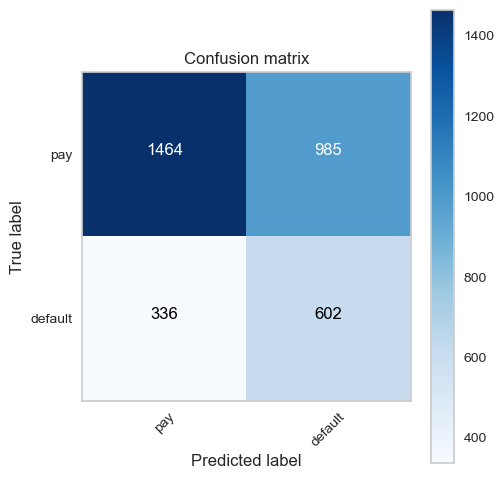

In [631]:
plot_confusion_matrix(y_test, y_test_pred3 >= 0.5, classes=["pay", "default"], normalize=False)

In [657]:
clf3 = CalibratedClassifierCV(estimator=baseline3, method='isotonic', cv="prefit").fit(x_valid[selected], y_valid)

In [659]:
calc_best_t(y_test, clf3.predict_proba(x_test[selected])[:,1], t=200, verbose=False)

[]

In [665]:
# можно сделать ансамбль, но тогда интерпретировать результат будет еще сложнее
pred1 = clf.predict_proba(x_test[selected])[:,1]
pred2 = clf2.predict_proba(x_test[selected + ["cluster"]])[:,1]
pred3 = clf3.predict_proba(x_test[selected])[:,1]

average_preds = np.average(np.concatenate([pred1[None, ...], pred2[None, ...], pred3[None, ...]], axis=0), axis=0)

In [666]:
calc_best_t(y_test, average_preds, t=200, verbose=False)

[(0.23090452261306532, 0.14543960558751026, 0.3593150280484204)]

In [667]:
average_preds = np.power(np.prod(np.concatenate([pred1[None, ...], pred2[None, ...], pred3[None, ...]], axis=0), axis=0), 1/3)

In [668]:
calc_best_t(y_test, average_preds, t=200, verbose=False)

[(0.23090452261306532, 0.14532019704433496, 0.3596102745792737)]

### Вывод: минимально рабочий baseline это первая модель.

Последняя оптимизирована под f1_score, не подобран баланс для precision/recall 

Стоит попобовать логистическую регрессию, добавив полиномиальные признаки, бины. Это позволит легче интрпретировать предсказание модели с помощью весовых регрессионных коэффициентов $z = ln(\frac{p}{1-p}) = x_1 * w_1 + ... x_n * w_n + b$, $F(x) = sigmoid(z)$

Более осознанно продумать стратегию использования данных об отказах (принимать отказ как за дефолт в данном случае странтегия нерабочая)

In [669]:
import shap

In [672]:
# вариант интерпретации (через shap, как и отбор признаков), сгенрированные признаки сложны для интерпретации, но задача такая не стояла

explainer = shap.TreeExplainer(baseline)
shap_values = explainer.shap_values(x_test[selected])

In [684]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1, :], x_test.iloc[0,:][selected], link="logit")

### Предложения

**признаки - обычно хорошо работают в такой задаче:**

* скоринговый балл заемщика (как из собственных, так и из сторонних источников);
* платежный паттерн;
* Личные данные: 
    - семейное положение, 
    - образование,
    - место работы, 
    - тип занятости, 
    - уровень заработной платы,
    - пол,
    - продолжительность работы на одном месте и общий стаж,
    - регион, уровень безработицы в регионе и в данной профессии,
    - наличие движимого и недвижимого имущества (в т.ч. обременненого кредитом)
    
* периодичность платежей;
* размер платежа;
* раннее погашение кредита (количество, суммы и т.д.);
* первоначальный взнос (для микро- не применимо);
* сумма полученного кредита;
* различные операции с ними и т.д.

